In [4]:
%matplotlib inline

import torch
from tensorflow.keras import backend as K
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from tensorflow.keras.layers import Conv2D, Input, Dense, MaxPool2D, Flatten, Lambda, GlobalMaxPool2D
from tensorflow.keras.models import Model
import tensorflow as tf
import matplotlib.pyplot as plt

from model import ConvNet
from CustomDataset import get_dataset

model = ConvNet(False)
model.cpu()
model.eval()
model.load_state_dict(torch.load('weights/Model_quicksave40.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [6]:
print(K.image_data_format())

with tf.device('/cpu:0'):
    inp = Input((None,300,1))
    x = Conv2D(1280,(5,300),activation='relu', name='conv1')(inp)
    
    # Reshaping to (BCHW)
    x = GlobalMaxPool2D('channels_last')(x)
    # Reshaping to (BCHW)
    #x = Lambda(lambda x: K.permute_dimensions(x, (0, 3, 1, 2)))(x)
    #x = Flatten()(x)
    z = Dense(160,name='fc1',activation='relu')(x)
    out = Dense(20,name='fc2')(z)
    k_model = Model(inp, out)

channels_last


In [8]:
trained_weights = model.state_dict()

pytorch_layers = [] # get ptroch layers names and suffixes
for x, l in zip(trained_weights, k_model.layers):
    #print(x)
    #print(l)
    #print(x.find('.'))
    pytorch_layers.append(x[:x.find('.')])

unique_layers = np.unique(pytorch_layers)
print(unique_layers)


['conv1' 'fc1' 'fc2']


In [9]:


for layer in unique_layers:
    weights = trained_weights['{}.weight'.format(layer)].cpu().numpy() # torch weights (nf, ch, x, y)
    biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
    if 'bn' in layer:
        running_mean = trained_weights['{}.running_mean'.format(layer)].cpu().numpy()
        running_var = trained_weights['{}.running_var'.format(layer)].cpu().numpy()
        W = [weights, biases, running_mean, running_var]
    elif 'fc' in layer:
        biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
        W = [weights.T, biases]
    else:
        W = [np.moveaxis(weights, [0, 1], [3, 2]), biases] # transpose to (x, y, ch, nf) keras version
    k_model.get_layer(layer).set_weights(W)

k_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, 300, 1)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, 1, 1280)     1921280   
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 1280)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 160)               204960    
_________________________________________________________________
fc2 (Dense)                  (None, 20)                3220      
Total params: 2,129,460
Trainable params: 2,129,460
Non-trainable params: 0
_________________________________________________________________


max difference: 3.8146973e-06 
sum of difffernces: 0.00010803342


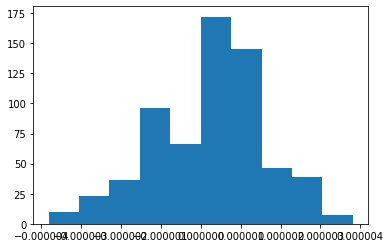

In [10]:


#### Verify

batch_size = 32

keras_input = np.random.random((batch_size, 400, 300, 1)).astype('float32')
pytorch_input = torch.from_numpy(keras_input.transpose(0,-1,1,2))

p_out = model(pytorch_input.cpu())
k_out = k_model.predict(keras_input)

y = torch.from_numpy(k_out) - p_out
y = y.detach().numpy().flatten()
plt.hist(y);
print('max difference:', y.max(), '\nsum of difffernces:', y.sum())